# Getting Started with Sentiment Analysis on Twitter

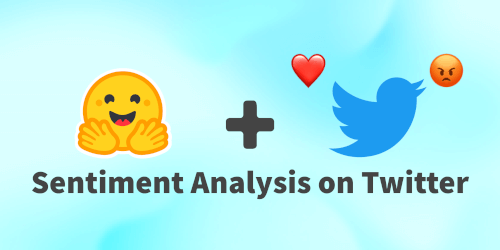

## 1. Install dependencies

In [1]:
!pip install -q tweepy matplotlib wordcloud

## 2. Set up Twitter API credentials





In [ ]:
import tweepy

# Add Twitter API key and secret
consumer_key = "XXXXX"
consumer_secret = "XXXXX"

# Handling authentication with Twitter
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

# Create a wrapper for the Twitter API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## *3. Search for tweets using Tweepy*

In [ ]:
# Helper function for handling pagination in our search and handle rate limits
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Reached rate limite. Sleeping for >15 minutes')
            time.sleep(15 * 61)
        except StopIteration:
            break

# Define the term we will be using for searching tweets
query = '@notionhq'
query = query + ' -filter:retweets'

# Define how many tweets to get from the Twitter API 
count = 1000

# Search for tweets using Tweepy 
search = limit_handled(tweepy.Cursor(api.search,
                        q=query,
                        tweet_mode='extended',
                        lang='en',
                        result_type="recent").items(count))

# Process the results from the search using Tweepy
tweets = []
for result in search:
  tweet_content = result.full_text
  # Only saving the tweet content. 
  # You could also save other attributes for each tweet like date or # of RTs.
  tweets.append(tweet_content)

## 4. Run sentiment analysis on the tweets

In [ ]:
import requests
import time

# Set up the API call to the Inference API to do sentiment analysis
model = "cardiffnlp/twitter-roberta-base-sentiment-latest"
hf_token = "XXXXX"
API_URL = "https://api-inference.huggingface.co/models/" + model
headers = {"Authorization": "Bearer %s" % (hf_token)}
def analysis(payload):
  response = requests.post(API_URL, headers=headers, json=payload)
  while "is currently loading" in str(response.json()): # retry request while model loads
    print(response.json())
    time.sleep(15)
    response = requests.post(API_URL, headers=headers, json=payload)
  return response.json()

# Let's run the sentiment analysis on each tweet
tweets_analysis = []
for tweet in tweets:
    try:
      sentiment_result = analysis(tweet)[0]
      top_sentiment = max(sentiment_result, key=lambda x: x['score']) # Get the sentiment with the higher score     
      tweets_analysis.append({'tweet': tweet, 'sentiment': top_sentiment['label']})

    except Exception as e: 
      print(e)

## 5.Explore the results of sentiment analysis

In [ ]:
import pandas as pd

# Load the data in a dataframe
pd.set_option('max_colwidth', None)
pd.set_option('display.width', 3000) 
df = pd.DataFrame(tweets_analysis)

# Show a tweet for each sentiment 
display(df[df["sentiment"] == 'Positive'].head(20))
display(df[df["sentiment"] == 'Neutral'].head(20))
display(df[df["sentiment"] == 'Negative'].head(20))

,tweet,sentiment
2,@Cron @NotionHQ @raphaelschaad I would love to have an early invite pls 🙏🏻,Positive
4,@IanDikhtiar @vincentgrattery @NotionHQ Isn't it this very concept? :),Positive
5,@IAmPascio @hypefury @NotionHQ thanks - pretty much!,Positive
9,@NotionHQ @mounika_2000 @ElosNotion @NotionUtopia 3. Paid Notion Avatar By @heyzoish \n\nZoish is an amazing artist and recently gave away a ton of free avatars to people on Twitter! https://t.co/HIHPr1kNni,Positive
10,@NotionHQ @mounika_2000 2. Paid Notion Avatar by @ElosNotion \n\nEloise creates stunning avatars which you purchase through @NotionUtopia. I believe they even have an offer for creators. https://t.co/8eLkz76qfr,Positive
14,😀 I create @NotionHQ templates to help you stay at the top of your game!\n \nYou will like this ✨ template: https://t.co/YGcxfEtMFc,Positive
15,@_yudax @NotionHQ Epic 😂,Positive
16,@JhumanJ @NotionHQ That is sexyyy !!!,Positive
18,"@NotionHQ \n\nI downloaded this the other day and even the free version lives up to all the hype about it. Tasks, projects, goals, and notes - it’s all there. Probably makes the next two redundant but nonetheless…",Positive
19,"I tend to accomplish more when I plan my week out. Here's a free @NotionHQ template to help you plan yours out too. \n\n Free Weekly, Daily Planner on @Gumroad https://t.co/VFVeoZwW4K",Positive


,tweet,sentiment
0,@dePAKES @vincentgrattery @NotionHQ My time already ran out. I am living my last day every day.\n\n“Think of yourself as dead. You have lived your life. Now take what’s left and live properly.” - Marcus Aurelius,Neutral
7,"@NotionHQ @mounika_2000 @ElosNotion @NotionUtopia @heyzoish @heysallywong 5. Free DIY Notion Avatar by @felix12777 \n\nMost avatars you see, like the one I have, come from an online avatar generator. The illustrations are provided by Felix Wong (and it's free, yes)\n\nIf you like to DIY, you can also get his pack of illustrations to put together yourself https://t.co/POyIATUv86",Neutral
8,"@NotionHQ @mounika_2000 @ElosNotion @NotionUtopia @heyzoish 4. Paid Notion Avatar by @heysallywong \n\nSally is the OG when it comes to Notion avatars, and she's done many of them. Is she going to do yours next? https://t.co/DUvR1ZvOFS",Neutral
11,@NotionHQ 1. Paid Notion Avatar by @mounika_2000 \n\nMounika will deliver your uniquely hand-drawn Notion avatar in 5-8 days or less and do other visual work as well. https://t.co/5uohgs0F4K,Neutral
12,"One of the things I get asked the most:\n\n""How do you get the @NotionHQ avatar profile picture?""\n\nHere are 5 ways to get your own avatar:",Neutral
13,@IanDikhtiar @vincentgrattery @NotionHQ Memento mori,Neutral
17,@itskeeplearning @NotionHQ How you've linked gallery cards?,Neutral
20,@JhumanJ @NotionHQ Big head 😂\nhttps://t.co/GjsJKjDRtR,Neutral
21,@stufflistings @NotionHQ is more productive,Neutral
22,@IAmPascio @NotionHQ @NotionPlaza @NotionUtopia @notionery @notionjoy @notionway @GetPrototion Also\nhttps://t.co/GyJODTQtpn by @iNotionHQ,Neutral


,tweet,sentiment
1,"@IanDikhtiar @vincentgrattery @NotionHQ Got it! On the other hand, it shows you that your time is running out and 23% of your life already over...No?",Negative
3,"@dePAKES @vincentgrattery @NotionHQ To me is more of a reminder that I can die RIGHT NOW, not in 73%",Negative
6,"@dePAKES @vincentgrattery @NotionHQ Lol, I actually think this bar is completely opposite of memetro Mori idea.",Negative
37,"@Shasko @figma @NotionHQ @SShuaiqi @tryorchestra Organisation or enterprise plan. But yea, if you’re not working in a big company that pays 50$/month for an org plan, it sucks. Sorry for the confusion. Will change for me too, since I’ll start as a freelancer soon and I am not sure if I will invest that 50$ monthly.",Negative
39,"@UXdrasil @figma @NotionHQ @SShuaiqi @tryorchestra I didn't this exist, then I Google it to learn, then cried because only on enterprise plan 😭",Negative
46,"So, I’m using @NotionHQ for literally everything these days. But I’m beginning to fear how much I’m relying on this free tool. If it collapses, I have no back up. Suggestions?",Negative
52,@NotionHQ Running into an issue here recently were content is not showing on on web but still in the app. This happens for all of our pages. https://t.co/3J3AnGzDau,Negative
88,@NotionHQ problem while exporting using the current view option https://t.co/UInzeh069c,Negative
89,@jasonleowsg @NotionHQ @CausalHQ @golifelog Or you could go with the nuclear option 😂 and make users pay a bounty when they fail to keep using the product like https://t.co/2GDj6BylOb or https://t.co/9YKiI9Vo7b,Negative
96,@navstring @figma @NotionHQ @SShuaiqi @tryorchestra Ah sorry! It's for the org and enterprise plans only. Sorry that I didnt mention that :( https://t.co/6Wm1g0MfSa,Negative


sentiment
Negative     82
Neutral     420
Positive    498
dtype: int64


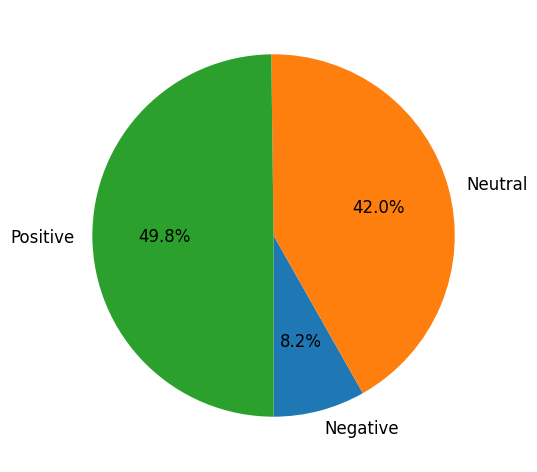

In [ ]:
import matplotlib.pyplot as plt

# Let's count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

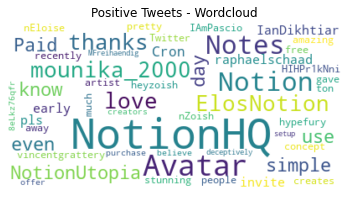

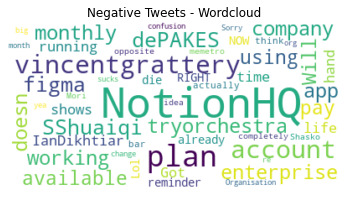

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud with positive tweets
positive_tweets = df['tweet'][df["sentiment"] == 'Positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative tweets
negative_tweets = df['tweet'][df["sentiment"] == 'Negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()